# Alaska Geomagnetic Field Prediction: LSTM STG Tutorial Notebook

During periods of strong geomagnetic activity, electric fields formed within the conductive parts of the Earth's crust can induce damaging currents within power lines and other electrical devices. To predict where and when these currents may form, we utilize solar wind and interplanetary magnetic field information to discern where strong geomagnetic activity may occur. The goal of the code in this notebook is to predict what the upcoming geomagnetic field may be using 30 minutes of solar wind information for a specific magnetometer location. 

In [1]:
from datetime import datetime,timedelta
import os

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import scipy.stats as ss

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [2]:
tf.__version__

'2.7.0'

## Data Ingest and Pre-Processing

SuperMAG hosts a global set of magnetometer data from which we chose the College Alaska station. This dataset includes geomagnetic field information at the location recorded every minute and its position in magnetic local time. The geomagnetic field data has been pre-processed by SuperMAG to remove yearly and median baselines, making it easy to work with. The NASA OMNIweb dataset provides interplanetary magnetic field (IMF magnitude and the Z component) and solar wind information (we utilized solar wind speed, pressure, density, and temperature) which provides the model immediate information on the state of the solar wind. We utilize 30 minutes of this information as input to the model since propagation of geomagnetic disturbances from the outer magnetic field to the surface vary in timing. The data pre-processing takes 30 minutes of OMNI data, station magnetic local time information encoded with sine and cosine, and last known geomagnetic field derivative and processes it into a 2D information array normalized with cube root for each geomagnetic field point. The data is split into two sets, one for training, which updates the LSTM weights, and another for validation which checks how well the current model handles data it hasn't trained off of. Generally we aim for roughly a 2:1 training to validation set ratio.

In [3]:
mag_path = '/efs/STG_Tutorial_Data/Helio_LSTM/Tutorial/MAG'
omni_path = '/efs/STG_Tutorial_Data/Helio_LSTM/Tutorial/OMNI'

In [4]:
def read_omni(opath):
    time = list()
    Bx = list()
    By = list()
    Bz = list()
    Bmag = list()
    Speed = list()
    Density = list()
    Temp = list()
    Pressure = list()
    AE = list()
    SYMH = list()
    with open(opath) as file:
        for line in file:
            datacols = line.strip("\n").split()

            # first 4 cols are date info
            # turn these into a timestamp
            datestr = '{:04d}-{:03d} {:02d}:{:02d}:00'.format(int(datacols[0]), int(datacols[1]), int(datacols[2]), int(datacols[3]))
            timestamp = datetime.strptime(datestr, "%Y-%j %H:%M:%S")
            stamp = timestamp.strftime("%Y-%m-%d %H:%M:%S")

            time.append(stamp)

            Bx.append(np.nan) if float(datacols[4]) == 9999.99 else Bx.append(float(datacols[4]))
            By.append(np.nan) if float(datacols[5]) == 9999.99 else By.append(float(datacols[5]))
            Bz.append(np.nan) if float(datacols[6]) == 9999.99 else Bz.append(float(datacols[6]))
            if ((float(datacols[4])!= 9999.99) and (float(datacols[5]) != 9999.99) and (float(datacols[6] != 9999.99))):
                Bmag.append(np.sqrt( float(datacols[4])**2 + float(datacols[5])**2 + float(datacols[6])**2 ))
            else:
                Bmag.append(np.nan)
            Speed.append(np.nan) if float(datacols[7]) == 99999.9 else Speed.append(float(datacols[7]))
            Density.append(np.nan) if float(datacols[8]) == 999.99 else Density.append(float(datacols[8]))
            Temp.append(np.nan) if float(datacols[9]) == 9999999. else Temp.append(float(datacols[9])/11604.518)
            Pressure.append(np.nan) if float(datacols[10]) == 99.99 else Pressure.append(float(datacols[10]))
            AE.append(int(datacols[11]))
            SYMH.append(int(datacols[12]))

    omni = pd.DataFrame({'date': time, 'Bmag': Bmag, 'Bz': Bz, 'Speed': Speed, 'Density': Density, 'Pressure': Pressure, 'Temp': Temp})
    # omni = pd.DataFrame({'date': time, 'Bmag': Bmag, 'Bx':Bx, 'By':By, 'Bz': Bz, 'Speed': Speed, 'Density': Density, 'Pressure': Pressure, 'Temp': Temp})
    omni['date'] = pd.to_datetime(omni['date'])
    omni = omni.set_index('date')
    return omni

def prep_batch(data, batch):
    # when training with a batch size
    # the incoming dataset needs to perfectly fit an
    # integer amount of batches, otherwise it will crash on the final batch
    # this function removes 1 line of data until it achieves
    # number of batches * batch size = length of dataset
    modul = np.mod(data.shape[0], batch)
    while modul != 0:
        data = data[:-1, :]
        datalen = data.shape[0]

        modul = np.mod(datalen, batch)

    #print(np.mod(data.shape[0], batch))
    return(data)

def to_supervised(data, lag):
    # this function shifts the values 1 time for the
    # amount of time history set by lag
    # this also labels each new column with what
    # variable and time the variable is at
    # i.e., Pressure (t-3) means Pressure 3 minutes prior to the timestamp
    col, names = list(), list()
    col = [data.shift(i) for i in range(1, lag+1)]
    vars = data.columns.values
    for l in vars:
        names.append('{} (t-0)'.format(l))
    for i in range(1, lag+1):
        for j in vars:
            names.append('{} (t-{})'.format(j, i))
    col.append(data)
    data = pd.concat(col, axis=1)
    data.columns = names

    return data

def get_testing(lag, magpath, omnipath):
    # this function grabs the 2015 testing set
    # this outputs the transforms input data, the true data
    # and the list of the timestamps for each data point
    mag2015 = pd.read_csv(os.path.join(magpath, "2015-cmo1yr-supermag.csv"), header=0, usecols=[0, 7, 9], parse_dates=["Date_UTC"], index_col=0)
    omni2015 = read_omni(os.path.join(omnipath, "omni_min_2015.lst"))

    # linear interpolation to fill in small gaps
    omni2015 = omni2015.interpolate(method="linear", limit=10, limit_direction="forward")
    omni2015 = omni2015.dropna()

    # merging the two datasets resets the index which was the datetime stamps
    # we copy the index as a second column to retain this information after the merge
    omni2015['indcop'] = omni2015.index
    data = omni2015.merge(mag2015, left_index=True, right_index=True)
    data['indcop'] = pd.to_datetime(data['indcop'])
    data = data.set_index('indcop')

    # convert the MLT values into sine and cosine
    # this conserves the cyclic dependence on MLT
    # cos and sin both needed - allows for a value when one is reporting 0
    data['sinmlt'] = np.sin(2. * np.pi * data['MLT'] / 24.)
    data['cosmlt'] = np.cos(2. * np.pi * data['MLT'] / 24.)

    # drop MLT and unneeded mag values
    data = data.drop(['MLT'], axis=1)

    # take the magnitude of the geomagnetic field
    # then derive db/dt information
    # we are assuming 1 minute cadence
    # we remove values where the time difference is greater than
    # 1 minute to preserve expected 1 minute cadence
    # this does not remove the fact a gap exists
    # we are choosing to have the model assume the gaps aren't there
    data['dbn_nez'] = np.abs(data['dbn_nez'])
    data['dbndt'] = data['dbn_nez'].diff()
    data['tdiff'] = data.index.to_series().diff()
    data = data[data['tdiff'] < timedelta(minutes=2)]
    data = data.drop(['tdiff'], axis=1)

    # grab observed data
    observed = data['dbn_nez'].values[lag:]
    observed = observed.astype("float16")
    data = data.drop(['dbn_nez'], axis=1)


    scalertype = "cbrt"
    if scalertype == "cbrt":
        data[data.columns] = np.cbrt(data[data.columns])
    if scalertype == "log":
        # signed log, performs a log norm on both sides of zero
        # values that were original negative keep their negative sign
        data[data > 0] = np.log(data[data > 0] + 1)
        data[data < 0] = -1*np.log(np.abs(data[data < 0]) + 1)

    features = data.shape[1]
    data = to_supervised(data, lag)
    testing2015 = data.values[lag:, :(lag*features)]
    stamps = data.index.values[lag:]
    testing2015 = testing2015.astype("float16")
    testing2015 = testing2015.reshape(testing2015.shape[0], lag, features)
    return testing2015, observed, stamps

In [5]:
mag_data = pd.read_csv(os.path.join(mag_path, "2014-cmo1yr-supermag.csv"),
                       header=0, 
                       usecols=[0,7,9], 
                       parse_dates=["Date_UTC"], 
                       index_col=0)
mag_data

,MLT,dbn_nez
Date_UTC,,
2014-01-01 00:00:00,12.52,0.4
2014-01-01 00:01:00,12.53,0.6
2014-01-01 00:02:00,12.55,0.5
2014-01-01 00:03:00,12.57,0.7
2014-01-01 00:04:00,12.58,1.1
...,...,...
2014-12-31 23:55:00,12.44,-7.9
2014-12-31 23:56:00,12.45,-8.6
2014-12-31 23:57:00,12.47,-7.2


In [6]:
mag_data.describe().T

,count,mean,std,min,25%,50%,75%,max
MLT,523330.0,11.935029,6.956940,0.0,5.88,11.92,17.95,24.0
dbn_nez,523330.0,-12.289484,76.113377,-1318.1,-11.30,-1.00,7.60,745.9


In [7]:
omni_data = read_omni(os.path.join(omni_path, "omni_min_2014.lst"))
omni_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Bmag,459352.0,5.924194,2.887210,0.130767,4.089621,5.420461,7.042697,31.398642
Bz,459352.0,0.219885,3.617817,-18.230000,-1.990000,0.160000,2.280000,28.770000
Speed,378345.0,396.980701,79.195214,248.800000,341.600000,381.400000,436.000000,944.000000
Density,378345.0,6.160344,4.487193,0.320000,3.350000,5.020000,7.500000,65.820000
Pressure,378345.0,1.848512,1.445632,0.130000,1.040000,1.470000,2.160000,27.540000
Temp,377772.0,6.949673,7.083568,0.251971,2.693606,5.059323,8.633405,398.264710


In [8]:
def preProcessData(omni_data, mag_data):
    # linear interpolation to fill in small gaps
    omni_data = omni_data.interpolate(method="linear", limit=10, limit_direction="forward")
    omni_data = omni_data.dropna()
    # merging the two datasets resets the index which was the datetime stamps
    # we copy the index as a second column to retain this information after the merge
    omni_data['indcop'] = omni_data.index
    data = omni_data.merge(mag_data, left_index=True, right_index=True)
    data['indcop'] = pd.to_datetime(data['indcop'])
    data = data.set_index('indcop')
    # convert the MLT values into sine and cosine
    # this conserves the cyclic dependence on MLT
    # cos and sin both needed - allows for a value when one is reporting 0
    data['sinmlt'] = np.sin(2. * np.pi * data['MLT'] / 24.)
    data['cosmlt'] = np.cos(2. * np.pi * data['MLT'] / 24.)
    
    # drop MLT and unneeded mag values
    data = data.drop(['MLT'], axis=1)

    # take the magnitude of the geomagnetic field
    # then derive db/dt information
    # we are assuming 1 minute cadence
    # we remove values where the time difference is greater than
    # 1 minute to preserve expected 1 minute cadence
    # this does not remove the fact a gap exists
    # we are choosing to have the model assume the gaps aren't there
    data['dbn_nez'] = np.abs(data['dbn_nez'])
    data['dbndt'] = data['dbn_nez'].diff()
    data['tdiff'] = data.index.to_series().diff()
    data = data[data['tdiff'] < timedelta(minutes=2)]
    data = data.drop(['tdiff'], axis=1)
    return data

In [9]:
data = preProcessData(omni_data, mag_data)

In [10]:
# cube root is easy to apply and reverse for normalization
# it also has the advantage of keeping relative gaps though not quite as
# performant in this as a log norm does
# log may also be utilized however we are dealing with positive/negative values
# so proper care must be taken when utilizing a log norm
scalertype = "cbrt"
if scalertype == "cbrt":
    data[data.columns] = np.cbrt(data[data.columns])
if scalertype == "log":
    # signed log, performs a log norm on both sides of zero
    # values that were original negative keep their negative sign
    data[data > 0] = np.log(data[data > 0]+1)
    data[data < 0] = -1*np.log(np.abs(data[data < 0]) + 1)

In [11]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Bmag,466452.0,1.769750,0.266038,0.507574,1.598683,1.756768,1.917296,3.154789
Bz,466452.0,0.069805,1.335669,-2.631857,-1.259921,0.553966,1.318090,3.064173
Speed,466452.0,7.315588,0.459472,6.289510,6.987051,7.251407,7.576985,9.809736
Density,466452.0,1.749362,0.374985,0.683990,1.493303,1.709976,1.954820,4.037563
Pressure,466452.0,1.171687,0.241195,0.506580,1.010555,1.134447,1.288659,3.019868
Temp,466452.0,1.775613,0.498135,0.631612,1.403176,1.726924,2.057104,7.357393
dbn_nez,466452.0,2.433335,1.342616,0.000000,1.560491,2.110454,2.912275,10.964347
sinmlt,466452.0,0.000946,0.842201,-1.000000,-0.889337,0.173646,0.883763,1.000000
cosmlt,466452.0,0.005136,0.848137,-1.000000,-0.893216,0.198775,0.897011,1.000000
dbndt,466452.0,-0.005891,1.326380,-5.561298,-1.062659,0.000000,1.062659,6.827770


In [12]:
# this is our split for training to validation data
stime = datetime(2014, 8, 31, 0, 0, 0)
train_data = data.loc[:stime]
test_data = data.loc[stime:]
print('Number of training points: {}'.format(len(train_data.index)))
print('Number of test points:     {}'.format(len(test_data.index)))

Number of training points: 317951
Number of test points:     148502


In [13]:
obs_vals = ['dbn_nez'] # this needs to be changed if training for a different geomagnetic field variable
X_train, X_valid = train_data.drop(obs_vals, axis=1), test_data.drop(obs_vals, axis=1)
y_train, y_valid = train_data[obs_vals], test_data[obs_vals]
features = X_train.shape[1]
X_train.head()

,Bmag,Bz,Speed,Density,Pressure,Temp,sinmlt,cosmlt,dbndt
indcop,,,,,,,,,
2014-01-01 00:05:00,1.707529,-1.193483,7.282337,1.810026,1.209645,2.116021,-0.538821,-0.995879,0.736806
2014-01-01 00:06:00,1.710753,-1.282609,7.279822,1.799794,1.202771,2.091173,-0.544691,-0.995599,0.464159
2014-01-01 00:07:00,1.711607,-1.362616,7.279822,1.799794,1.202771,2.091127,-0.550434,-0.995310,-0.669433
2014-01-01 00:08:00,1.712806,-1.401020,7.295199,1.827659,1.226494,2.101306,-0.553258,-0.995162,-0.843433
2014-01-01 00:09:00,1.686658,-0.638250,7.310512,1.854700,1.249333,2.111386,-0.558819,-0.994859,-0.793701


In [14]:
y_train.head()

,dbn_nez
indcop,
2014-01-01 00:05:00,1.144714
2014-01-01 00:06:00,1.169607
2014-01-01 00:07:00,1.091393
2014-01-01 00:08:00,0.887904
2014-01-01 00:09:00,0.584804


In [15]:
lag = 30

Transform data into time series supervised training data. 

In [16]:
X_train_lag, X_valid_lag = to_supervised(X_train, lag), to_supervised(X_valid, lag)
X_train_lag.head()

,Bmag (t-0),Bz (t-0),Speed (t-0),Density (t-0),Pressure (t-0),Temp (t-0),sinmlt (t-0),cosmlt (t-0),dbndt (t-0),Bmag (t-1),...,dbndt (t-29),Bmag (t-30),Bz (t-30),Speed (t-30),Density (t-30),Pressure (t-30),Temp (t-30),sinmlt (t-30),cosmlt (t-30),dbndt (t-30)
indcop,,,,,,,,,,,,,,,,,,,,,
2014-01-01 00:05:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.707529,-1.193483,7.282337,1.810026,1.209645,2.116021,-0.538821,-0.995879,0.736806
2014-01-01 00:06:00,1.707529,-1.193483,7.282337,1.810026,1.209645,2.116021,-0.538821,-0.995879,0.736806,NaN,...,NaN,1.710753,-1.282609,7.279822,1.799794,1.202771,2.091173,-0.544691,-0.995599,0.464159
2014-01-01 00:07:00,1.710753,-1.282609,7.279822,1.799794,1.202771,2.091173,-0.544691,-0.995599,0.464159,1.707529,...,NaN,1.711607,-1.362616,7.279822,1.799794,1.202771,2.091127,-0.550434,-0.995310,-0.669433
2014-01-01 00:08:00,1.711607,-1.362616,7.279822,1.799794,1.202771,2.091127,-0.550434,-0.995310,-0.669433,1.710753,...,NaN,1.712806,-1.401020,7.295199,1.827659,1.226494,2.101306,-0.553258,-0.995162,-0.843433
2014-01-01 00:09:00,1.712806,-1.401020,7.295199,1.827659,1.226494,2.101306,-0.553258,-0.995162,-0.843433,1.711607,...,NaN,1.686658,-0.638250,7.310512,1.854700,1.249333,2.111386,-0.558819,-0.994859,-0.793701


In [17]:
X_train, X_valid = X_train_lag.values[lag:, :(lag*features)], X_valid_lag.values[lag:, :(lag*features)]
X_train, X_valid = X_train.astype("float16"), X_valid.astype("float16")

In [18]:
batch_size = 256

In [19]:
y_train, y_valid = y_train.values[lag:], y_valid.values[lag:]
y_train, y_valid = y_train.astype("float16"), y_valid.astype("float16")
y_train, y_valid = prep_batch(y_train, batch_size), prep_batch(y_valid, batch_size)

X_train, X_valid = prep_batch(X_train, batch_size), prep_batch(X_valid, batch_size)
# this reshapes the values into a 2D array that is sent to the model
X_train = X_train.reshape(X_train.shape[0], lag, features)
X_valid = X_valid.reshape(X_valid.shape[0], lag, features)

In [20]:
print('Input shape: {}'.format((lag, features)))

Input shape: (30, 9)


## Model Definition and Training

- Number of neurons: 64
- Activation function: Tanh
- Loss Function: Mean Squared Error
- Optimizer: Adam

In [21]:
model = Sequential()
model.add(LSTM(32, activation="tanh", input_shape=(lag, features)))
model.add(Dense(1))
model.compile(loss="mse", optimizer='adam')
model

2022-05-19 18:09:48.166099: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-19 18:09:48.236286: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-19 18:09:48.236975: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-19 18:09:48.238336: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the 

In [22]:
logdir = os.path.join("logs", datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

Fit the model using the training data. Done in batches of batch_size. We use the test set as our validation set to test for generalization.

- Epochs: 20
- Batch size: 256


In [23]:
%%time
history = model.fit(x=X_train, 
                    y=y_train, 
                    epochs=25,
                    batch_size=batch_size,
                    shuffle=False,
                    validation_data=(X_valid, y_valid), 
                    callbacks=[tensorboard_callback])

Epoch 1/25


2022-05-19 18:10:05.822997: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201


1241/1241 [==============================] - 8s 4ms/step - loss: 1.3151 - val_loss: 1.8753
Epoch 2/25
1241/1241 [==============================] - 4s 3ms/step - loss: 0.6302 - val_loss: 0.7688
Epoch 3/25
1241/1241 [==============================] - 4s 3ms/step - loss: 0.4829 - val_loss: 0.7068
Epoch 4/25
1241/1241 [==============================] - 4s 3ms/step - loss: 0.4491 - val_loss: 0.6741
Epoch 5/25
1241/1241 [==============================] - 4s 3ms/step - loss: 0.4305 - val_loss: 0.6432
Epoch 6/25
1241/1241 [==============================] - 4s 3ms/step - loss: 0.4186 - val_loss: 0.6525
Epoch 7/25
1241/1241 [==============================] - 4s 3ms/step - loss: 0.4071 - val_loss: 0.6102
Epoch 8/25
1241/1241 [==============================] - 4s 3ms/step - loss: 0.3985 - val_loss: 0.6010
Epoch 9/25
1241/1241 [==============================] - 4s 3ms/step - loss: 0.3920 - val_loss: 0.5968
Epoch 10/25
1241/1241 [==============================] - 4s 3ms/step - loss: 0.3863 - val_los

Visualize loss over training

In the first plot we can see how the model trained with the presented data. We can see how the error of the training set and validation set changed as we utilized the training set to update the internal weights of the LSTM model making the prediction. In many cases the loss of the training set will continually decline, so we look at the loss of the validation set to determine if the model is overfitting the training set. Steadily declining training loss but increasing validation generally indicates that we have begun overfitting the training data. It is also important to see if our setup has unexpected training outcomes, such as vanishing or exploding gradients, usually seen as a flat line or sudden extreme increases.

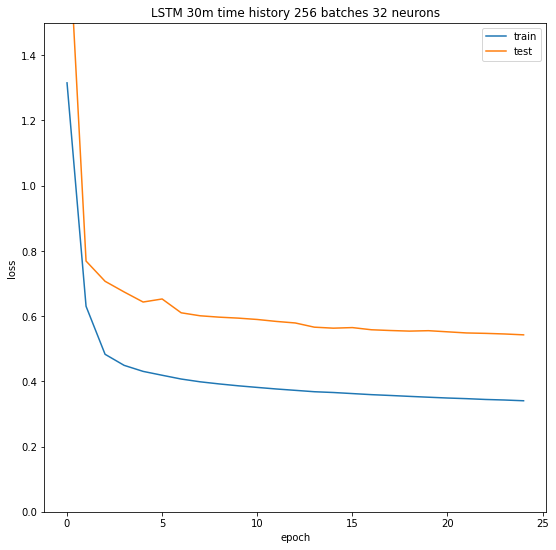

In [24]:
neurons = 32
plt.figure(figsize=(9,9))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.ylim([0,1.5])
plt.title("LSTM {}m time history {} batches {} neurons".format(lag, batch_size, neurons))
plt.show()

## Testing

This utilizes the model we just trained to make a prediction with new data that was not used at all within the training or validation sets. We chose the year 2015 due high geomagnetic activity, making it a good test set. The testing portion of the code pre-processes the SuperMAG and OMNIweb data in the same way the training and validation sets were prepared. After, the 2D information array is sent to the now trained LSTM model for it to predict the geomagnetic field. Since the model was trained on data with a cube root normalization, we have to take care and reverse this after the prediction, otherwise the predicted data points will not make sense.

In [25]:
testing, observed, stamps = get_testing(lag=lag, magpath=mag_path, omnipath=omni_path)

In [26]:
predicted = model.predict(testing)

In [27]:
# let's create a data frame for the observations and predictions
predicted = np.power(predicted[:, 0], 3)
results = pd.DataFrame({'Date':stamps[:], 'Observed':observed[:], 'Predicted':predicted[:]})
results = results.set_index("Date")
results

,Observed,Predicted
Date,,
2015-01-01 00:31:00,3.599609,5.188078
2015-01-01 00:32:00,2.500000,6.525764
2015-01-01 00:33:00,1.400391,4.923432
2015-01-01 00:34:00,1.000000,4.540935
2015-01-01 00:35:00,1.200195,4.607780
...,...,...
2015-12-31 23:55:00,31.406250,67.794792
2015-12-31 23:56:00,38.093750,104.549294
2015-12-31 23:57:00,36.687500,111.579590


In [28]:
# let's utilize a specific event to zoom into
event_start = '2015-09-07'
event_end = '2015-09-08 12:00'
grids = list()
event_obj = datetime.strptime(event_start, '%Y-%m-%d')
grids.append(event_obj)
for i in range(1, 10):
    grids.append(grids[i - 1] + timedelta(hours=4))

event = results[event_start:event_end]

In [29]:
import copy

# plot housekeeping
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['ytick.labelsize'] = 6
plt.rcParams['axes.labelsize'] = 8
plt.rcParams['axes.titlesize'] = 8
plt.rcParams['figure.constrained_layout.use'] = True

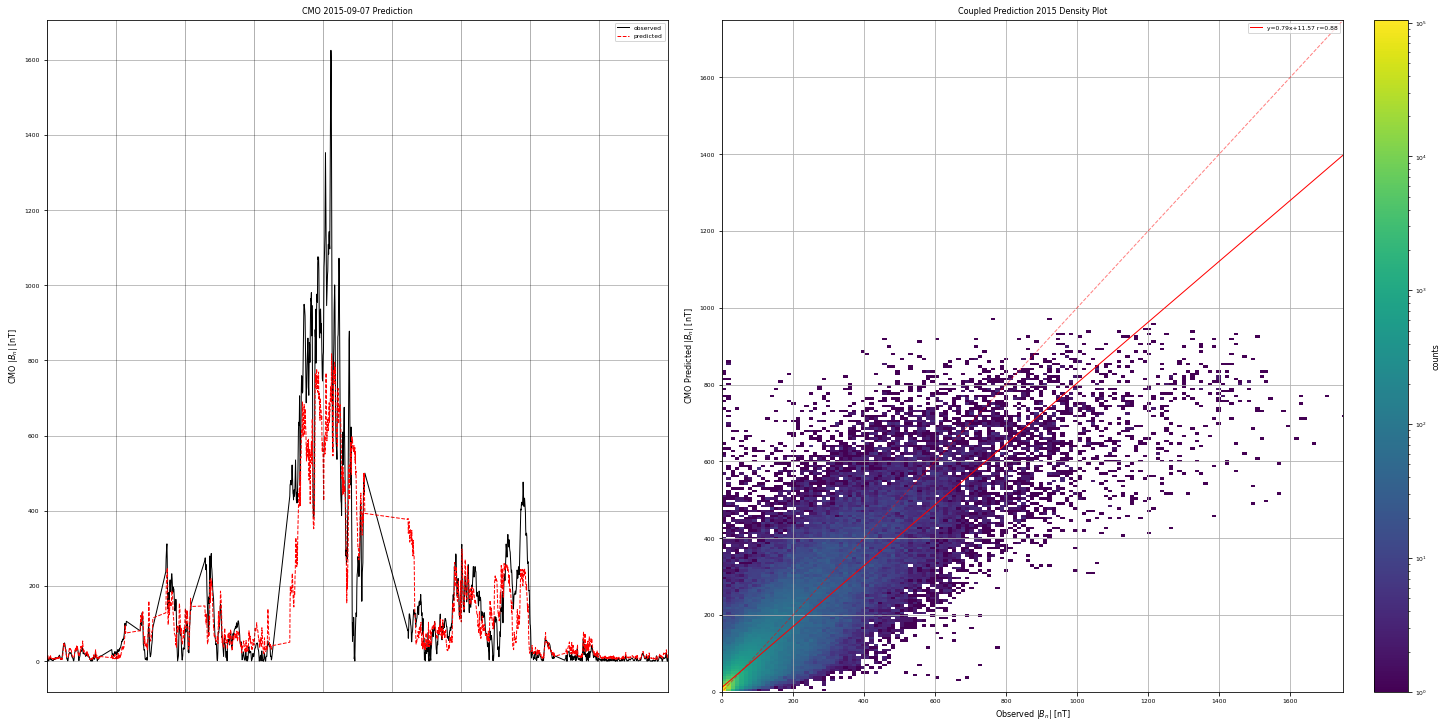

In [30]:
#setup the plotting window
fig = plt.figure(figsize=(20, 10))
gs = fig.add_gridspec(nrows=1, ncols=2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

# create a line plot of the selected event showing observations and prediction
ax1.plot(event.index.values, event["Observed"], label="observed", color='k', linewidth=1)
ax1.plot(event.index.values, event["Predicted"], label="predicted", color='r', linestyle="--", linewidth=1)
ax1.set_title("CMO {} Prediction".format(event_start))
ax1.set_xlabel("Universal Time [mm-dd hh]")
ax1.set_ylabel("CMO |$B_{n}$| [nT]")
ax1.grid()
ax1.get_xaxis().set_visible(False)
for g in grids:
    ax1.axvline(pd.Timestamp(g), color='k', alpha=0.3, linewidth=1, linestyle='-')
ax1.legend(loc="upper right", prop={'size': 6})
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=20)

cmap = copy.copy(mpl.cm.get_cmap('viridis'))
cmap.set_under(color="white")
histhandle = ax2.hist2d(results['Observed'].values.astype("float16"), results['Predicted'].values.astype("float16"), bins=[150, 150], cmap='viridis', norm=mpl.colors.LogNorm())
lineX = np.arange(-5000, 5000, 100)
lineX = lineX.reshape(-1, 1)
reg = LinearRegression().fit(results['Observed'].values.reshape(-1, 1), results['Predicted'].values.reshape(-1, 1))
coeffs = reg.coef_[0]
intercept = reg.intercept_
correl, pscore = ss.pearsonr(results['Observed'].values.astype("float16"), results['Predicted'].values.astype("float16"))
lineY = reg.predict(lineX)
ax2.set_title("Coupled Prediction 2015 Density Plot")
ax2.plot(lineX, lineY, color="red", label="y={:.2f}x+{:.2f} r={:.2f}".format(coeffs[0], intercept[0], correl), linewidth=1)
ax2.plot(lineX, lineX, color="red", linestyle="--", alpha=0.5, linewidth=1)
ax2.set_ylabel("CMO Predicted |$B_{n}$| [nT]")
ax2.set_xlabel("Observed |$B_{n}$| [nT]")
ax2.grid(True)
cbar = fig.colorbar(histhandle[3], ax=ax2)
cbar.ax.set_ylabel('counts', rotation=90)
ax2.legend(loc="upper right", prop={'size': 6})
ax2.set_ylim([0, 1750])
ax2.set_xlim([0, 1750])
plt.show()

See how the LSTM model performed on the test set. 

The final plot provides 2 different views of the predictions. First, the left plot shows a zoomed in prediction of a known geomagnetic storm in 2015. In this we can see how well the predicted (dashed red) line follows the observed (black) line during the storm. The right hand plot shows us a bulk view of all the data points within 2015. We use a density plot, which counts how many times for a specific bin the predicted and observed data overlap and maps the number of counts to a color for a quick visualization. This allows us to see things such as spots where the model is under or over predicting. For example, the model generally underpredicting 500 nT as 250 nT would be a high count blob within the density plot. We can see from the plot produced a lot of the counts are near 0-100 nT since the 2015 data is mostly quiet time data. To see the general trend of the data we then look at the line of best fit between the predicted and observed data. The dashed red line indicates the line of perfect prediction, if our LSTM model is performing perfectly all of the counts would lie along this line. The solid red line is the line of best fit between the predicted and observed data, we can see how this line deviates from the perfect prediction line to understand how our model predicts. A line of best fit below the dashed red line indicates our model is generally underpredicting the values while a line of best fit above the dashed red line indicates general overpredictions.

## Testing Pt. 2 - Fully Trained Model

Here we load up predictions that come from a more-fully trained mode and do the same analysis that we did on the smaller model that we trained in the above section.

In [32]:
# let's create a data frame for the observations and predictions
predicted = pd.read_csv('/efs/STG_Tutorial_Data/Helio_LSTM/CMO_final/CMO_AbsBn30_2015pred.csv', header=0, usecols=[0,2], parse_dates=["Date"], index_col=0)['magB (ML)'].values
results = pd.DataFrame({'Date':stamps[:], 'Observed':observed[:], 'Predicted':predicted[:]})
results = results.set_index("Date")
results

,Observed,Predicted
Date,,
2015-01-01 00:31:00,3.599609,2.137065
2015-01-01 00:32:00,2.500000,3.339320
2015-01-01 00:33:00,1.400391,2.329201
2015-01-01 00:34:00,1.000000,1.685552
2015-01-01 00:35:00,1.200195,1.638040
...,...,...
2015-12-31 23:55:00,31.406250,30.887115
2015-12-31 23:56:00,38.093750,55.474552
2015-12-31 23:57:00,36.687500,59.881950


In [33]:
# let's utilize a specific event to zoom into
event_start = '2015-09-07'
event_end = '2015-09-08 12:00'
grids = list()
event_obj = datetime.strptime(event_start, '%Y-%m-%d')
grids.append(event_obj)
for i in range(1, 10):
    grids.append(grids[i - 1] + timedelta(hours=4))

event = results[event_start:event_end]

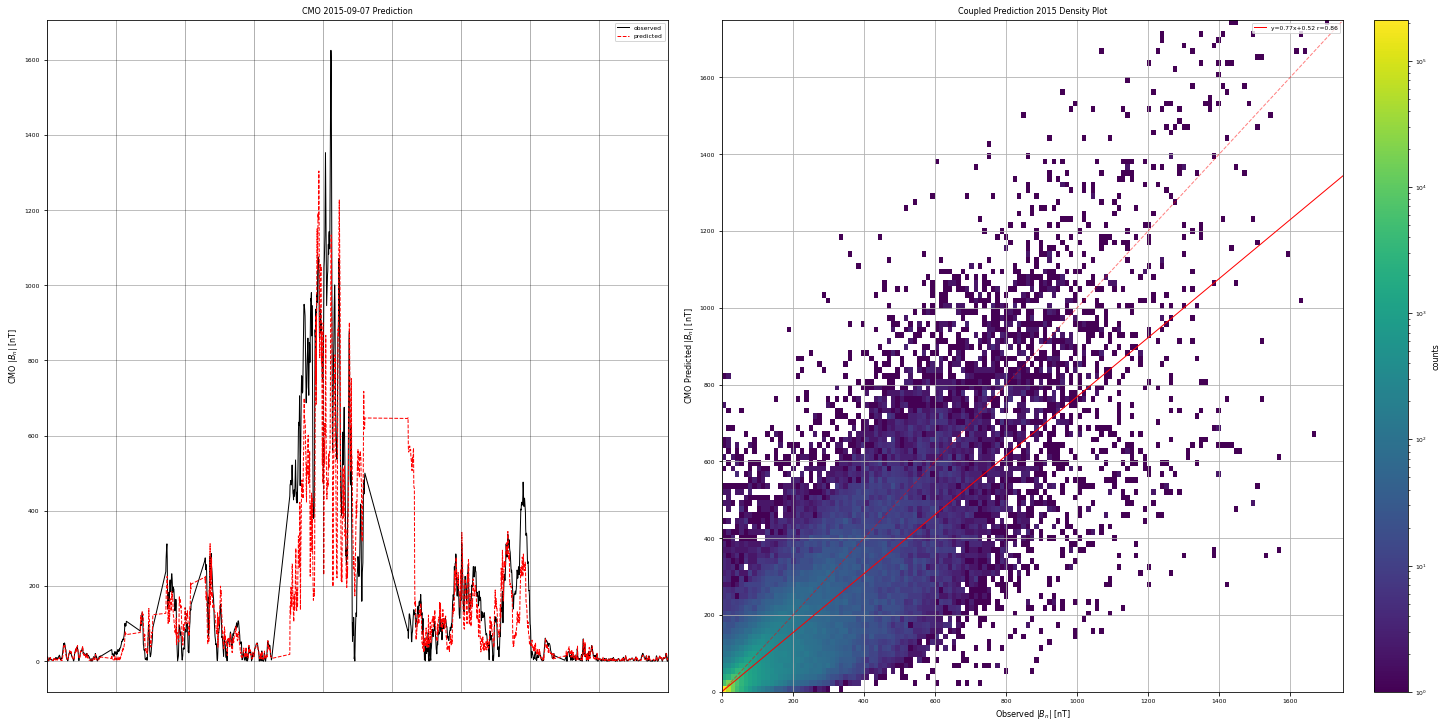

In [34]:
#setup the plotting window
fig = plt.figure(figsize=(20, 10))
gs = fig.add_gridspec(nrows=1, ncols=2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

# create a line plot of the selected event showing observations and prediction
ax1.plot(event.index.values, event["Observed"], label="observed", color='k', linewidth=1)
ax1.plot(event.index.values, event["Predicted"], label="predicted", color='r', linestyle="--", linewidth=1)
ax1.set_title("CMO {} Prediction".format(event_start))
ax1.set_xlabel("Universal Time [mm-dd hh]")
ax1.set_ylabel("CMO |$B_{n}$| [nT]")
ax1.grid()
ax1.get_xaxis().set_visible(False)
for g in grids:
    ax1.axvline(pd.Timestamp(g), color='k', alpha=0.3, linewidth=1, linestyle='-')
ax1.legend(loc="upper right", prop={'size': 6})
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=20)

cmap = copy.copy(mpl.cm.get_cmap('viridis'))
cmap.set_under(color="white")
histhandle = ax2.hist2d(results['Observed'].values.astype("float16"), results['Predicted'].values.astype("float16"), bins=[150, 150], cmap='viridis', norm=mpl.colors.LogNorm())
lineX = np.arange(-5000, 5000, 100)
lineX = lineX.reshape(-1, 1)
reg = LinearRegression().fit(results['Observed'].values.reshape(-1, 1), results['Predicted'].values.reshape(-1, 1))
coeffs = reg.coef_[0]
intercept = reg.intercept_
correl, pscore = ss.pearsonr(results['Observed'].values.astype("float16"), results['Predicted'].values.astype("float16"))
lineY = reg.predict(lineX)
ax2.set_title("Coupled Prediction 2015 Density Plot")
ax2.plot(lineX, lineY, color="red", label="y={:.2f}x+{:.2f} r={:.2f}".format(coeffs[0], intercept[0], correl), linewidth=1)
ax2.plot(lineX, lineX, color="red", linestyle="--", alpha=0.5, linewidth=1)
ax2.set_ylabel("CMO Predicted |$B_{n}$| [nT]")
ax2.set_xlabel("Observed |$B_{n}$| [nT]")
ax2.grid(True)
cbar = fig.colorbar(histhandle[3], ax=ax2)
cbar.ax.set_ylabel('counts', rotation=90)
ax2.legend(loc="upper right", prop={'size': 6})
ax2.set_ylim([0, 1750])
ax2.set_xlim([0, 1750])
plt.show()